# Класифікація текстів: Аналіз сентименту IMDb


## 1. Збір текстових даних

Використаємо датасет IMDb Movie Reviews для класифікації сентименту (позитивні/негативні відгуки).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Завантаження датасету IMDb...")
(X_train_seq, y_train), (X_test_seq, y_test) = imdb.load_data(num_words=10000)

print(f"Кількість тренувальних прикладів: {len(X_train_seq)}")
print(f"Кількість тестових прикладів: {len(X_test_seq)}")
print(f"\nРозподіл класів у тренувальній вибірці:")
print(f"Позитивні відгуки: {np.sum(y_train == 1)}")
print(f"Негативні відгуки: {np.sum(y_train == 0)}")

Завантаження датасету IMDb...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Кількість тренувальних прикладів: 25000
Кількість тестових прикладів: 25000

Розподіл класів у тренувальній вибірці:
Позитивні відгуки: 12500
Негативні відгуки: 12500


In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

print("Декодування відгуків...")
X_train_text = [decode_review(review) for review in X_train_seq]
X_test_text = [decode_review(review) for review in X_test_seq]

print("\n" + "="*80)
print("Приклад позитивного відгуку:")
print("="*80)
pos_idx = np.where(y_train == 1)[0][0]
print(X_train_text[pos_idx][:500] + "...")

print("\n" + "="*80)
print("Приклад негативного відгуку:")
print("="*80)
neg_idx = np.where(y_train == 0)[0][0]
print(X_train_text[neg_idx][:500] + "...")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Декодування відгуків...

Приклад позитивного відгуку:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to ever...

Приклад негативного відгуку:
? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how 

## 2. Попередня обробка тексту

### a. Токенізація та очищення

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def preprocess_text(text, remove_stopwords=True, apply_stemming=False):

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()

    tokens = word_tokenize(text)

    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    if apply_stemming:
        tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

sample_text = X_train_text[0][:200]
print("Оригінальний текст:")
print(sample_text)
print("\nПісля обробки (без стемінгу):")
print(preprocess_text(sample_text, remove_stopwords=True, apply_stemming=False))
print("\nПісля обробки (зі стемінгом):")
print(preprocess_text(sample_text, remove_stopwords=True, apply_stemming=True))

Оригінальний текст:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the sa

Після обробки (без стемінгу):
film brilliant casting location scenery story direction everyones really suited part played could imagine robert amazing actor sa

Після обробки (зі стемінгом):
film brilliant cast locat sceneri stori direct everyon realli suit part play could imagin robert amaz actor sa


### b. Застосування лематизації та стемінгу

In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def preprocess_with_lemmatization(text, remove_stopwords=True):

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    tokens = word_tokenize(text)

    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

print("Порівняння методів нормалізації:")
print("="*80)
test_words = ["running", "ran", "runs", "better", "good", "movies", "watched"]
print(f"{'Слово':<15} {'Стемінг':<15} {'Лематизація':<15}")
print("-"*45)
for word in test_words:
    stemmed = stemmer.stem(word)
    lemmatized = lemmatizer.lemmatize(word)
    print(f"{word:<15} {stemmed:<15} {lemmatized:<15}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Порівняння методів нормалізації:
Слово           Стемінг         Лематизація    
---------------------------------------------
running         run             running        
ran             ran             ran            
runs            run             run            
better          better          better         
good            good            good           
movies          movi            movie          
watched         watch           watched        


In [ ]:
print("Обробка тренувальних даних...")
X_train_processed = [preprocess_with_lemmatization(text) for text in X_train_text]

print("Обробка тестових даних...")
X_test_processed = [preprocess_with_lemmatization(text) for text in X_test_text]

print("Обробка завершена!")
print(f"\nПриклад обробленого тексту:")
print(X_train_processed[0][:300] + "...")

Обробка тренувальних даних...
Обробка тестових даних...
Обробка завершена!

Приклад обробленого тексту:
film brilliant casting location scenery story direction everyones really suited part played could imagine robert amazing actor director father came scottish island loved fact real connection film witty remark throughout film great brilliant much bought film soon released would recommend everyone wat...


## 3. Векторизація

### a. Bag of Words та TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

print("Створення Bag of Words представлення...")
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train_processed)
X_test_bow = bow_vectorizer.transform(X_test_processed)

print(f"Розмірність BoW матриці: {X_train_bow.shape}")
print(f"Кількість унікальних слів: {len(bow_vectorizer.vocabulary_)}")

print("\nСтворення TF-IDF представлення...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

print(f"Розмірність TF-IDF матриці: {X_train_tfidf.shape}")

Створення Bag of Words представлення...
Розмірність BoW матриці: (25000, 5000)
Кількість унікальних слів: 5000

Створення TF-IDF представлення...
Розмірність TF-IDF матриці: (25000, 5000)


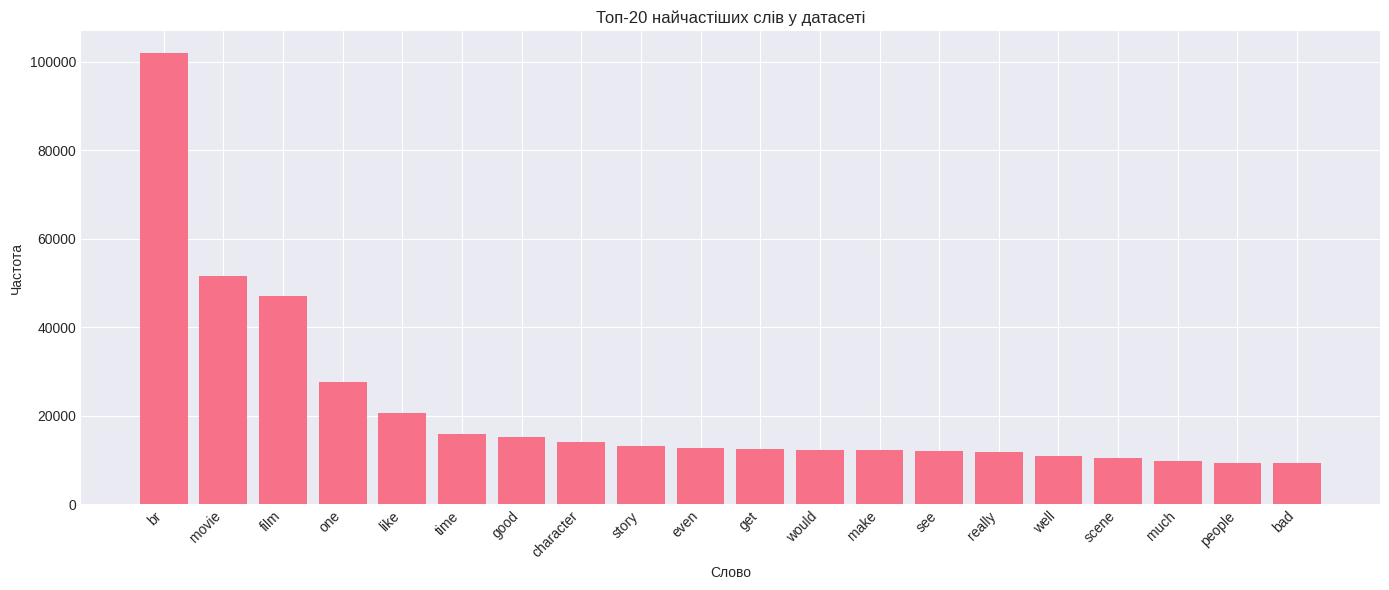


Топ-20 найчастіших слів:
     word  count
       br 101871
    movie  51635
     film  46994
      one  27710
     like  20738
     time  15915
     good  15157
character  14165
    story  13123
     even  12650
      get  12473
    would  12238
     make  12215
      see  11997
   really  11734
     well  10849
    scene  10555
     much   9758
   people   9357
      bad   9270


In [ ]:
feature_names = bow_vectorizer.get_feature_names_out()
word_counts = np.asarray(X_train_bow.sum(axis=0)).ravel()
word_freq = pd.DataFrame({'word': feature_names, 'count': word_counts})
word_freq = word_freq.sort_values('count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(range(20), word_freq['count'][:20])
plt.xticks(range(20), word_freq['word'][:20], rotation=45, ha='right')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.title('Топ-20 найчастіших слів у датасеті')
plt.tight_layout()
plt.show()

print("\nТоп-20 найчастіших слів:")
print(word_freq[['word', 'count']].head(20).to_string(index=False))

In [ ]:
doc_idx = 0

bow_doc = X_train_bow[doc_idx].toarray().ravel()
bow_words = [(feature_names[i], bow_doc[i]) for i in np.argsort(bow_doc)[::-1][:10] if bow_doc[i] > 0]

tfidf_doc = X_train_tfidf[doc_idx].toarray().ravel()
tfidf_words = [(feature_names[i], tfidf_doc[i]) for i in np.argsort(tfidf_doc)[::-1][:10] if tfidf_doc[i] > 0]

print("Топ-10 слів за BoW:")
for word, score in bow_words:
    print(f"{word}: {score:.4f}")

print("\nТоп-10 слів за TF-IDF:")
for word, score in tfidf_words:
    print(f"{word}: {score:.4f}")

Топ-10 слів за BoW:
film: 6.0000
amazing: 3.0000
brilliant: 3.0000
whole: 2.0000
story: 2.0000
child: 2.0000
played: 2.0000
really: 2.0000
think: 2.0000
say: 1.0000

Топ-10 слів за TF-IDF:
brilliant: 0.2964
amazing: 0.2911
film: 0.2169
child: 0.1702
fishing: 0.1666
played: 0.1635
praised: 0.1618
scottish: 0.1612
shared: 0.1612
norman: 0.1602


### b. Word2Vec та GloVe

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

tokenized_texts = [text.split() for text in X_train_processed]

print("Тренування Word2Vec моделі...")
word2vec_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1  
)

print(f"Розмір словника: {len(word2vec_model.wv)}")
print(f"Розмірність векторів: {word2vec_model.wv.vector_size}")

Тренування Word2Vec моделі...
Розмір словника: 8431
Розмірність векторів: 100


In [ ]:
def document_vector(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if len(word_vectors) == 0:
        return np.zeros(model.wv.vector_size)

    return np.mean(word_vectors, axis=0)

print("Створення векторів документів з Word2Vec...")
X_train_w2v = np.array([document_vector(text, word2vec_model) for text in X_train_processed])
X_test_w2v = np.array([document_vector(text, word2vec_model) for text in X_test_processed])

print(f"Розмірність тренувальної матриці: {X_train_w2v.shape}")
print(f"Розмірність тестової матриці: {X_test_w2v.shape}")

Створення векторів документів з Word2Vec...
Розмірність тренувальної матриці: (25000, 100)
Розмірність тестової матриці: (25000, 100)


In [ ]:
print("Приклади семантичної подібності в Word2Vec:")
print("="*80)

test_words = ['good', 'great', 'bad', 'movie', 'film']

for word in test_words:
    if word in word2vec_model.wv:
        similar_words = word2vec_model.wv.most_similar(word, topn=5)
        print(f"\nСхожі слова до '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")

Приклади семантичної подібності в Word2Vec:

Схожі слова до 'good':
  decent: 0.7549
  great: 0.7262
  bad: 0.7106
  excellent: 0.7004
  darn: 0.6881

Схожі слова до 'great':
  excellent: 0.8003
  fantastic: 0.7826
  wonderful: 0.7763
  fine: 0.7586
  marvelous: 0.7499

Схожі слова до 'bad':
  horrible: 0.7537
  terrible: 0.7452
  awful: 0.7274
  lousy: 0.7145
  good: 0.7106

Схожі слова до 'movie':
  film: 0.8658
  flick: 0.7207
  badness: 0.6842
  baseketball: 0.6777
  choke: 0.6745

Схожі слова до 'film':
  movie: 0.8658
  fellini: 0.7085
  distinction: 0.6958
  surpasses: 0.6832
  auteur: 0.6665


## 4. Побудова моделей

### a. Базовий класифікатор та логістична регресія

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Тренування Наївного Баєса з Bag of Words...")
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_bow.predict(X_test_bow)
accuracy_nb_bow = accuracy_score(y_test, y_pred_nb_bow)
print(f"Точність Наївного Баєса (BoW): {accuracy_nb_bow:.4f}")

print("\nТренування Наївного Баєса з TF-IDF...")
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
accuracy_nb_tfidf = accuracy_score(y_test, y_pred_nb_tfidf)
print(f"Точність Наївного Баєса (TF-IDF): {accuracy_nb_tfidf:.4f}")

Тренування Наївного Баєса з Bag of Words...
Точність Наївного Баєса (BoW): 0.8367

Тренування Наївного Баєса з TF-IDF...
Точність Наївного Баєса (TF-IDF): 0.8407


In [ ]:
print("Тренування Логістичної регресії з TF-IDF...")
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)
print(f"Точність Логістичної регресії (TF-IDF): {accuracy_lr_tfidf:.4f}")

print("\nТренування Логістичної регресії з Word2Vec...")
lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
lr_w2v.fit(X_train_w2v, y_train)
y_pred_lr_w2v = lr_w2v.predict(X_test_w2v)
accuracy_lr_w2v = accuracy_score(y_test, y_pred_lr_w2v)
print(f"Точність Логістичної регресії (Word2Vec): {accuracy_lr_w2v:.4f}")

Тренування Логістичної регресії з TF-IDF...
Точність Логістичної регресії (TF-IDF): 0.8800

Тренування Логістичної регресії з Word2Vec...
Точність Логістичної регресії (Word2Vec): 0.8633


### b. Розбиття даних та тренування

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

X_train_tfidf_tr, X_val_tfidf, y_train_tr, y_val = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42
)

print(f"Розмір тренувальної вибірки: {X_train_tfidf_tr.shape[0]}")
print(f"Розмір валідаційної вибірки: {X_val_tfidf.shape[0]}")
print(f"Розмір тестової вибірки: {X_test_tfidf.shape[0]}")

Розмір тренувальної вибірки: 20000
Розмір валідаційної вибірки: 5000
Розмір тестової вибірки: 25000


In [ ]:
print("Тренування Linear SVM...")
svm_model = LinearSVC(random_state=42, max_iter=2000)
svm_model.fit(X_train_tfidf_tr, y_train_tr)
y_pred_svm_val = svm_model.predict(X_val_tfidf)
y_pred_svm_test = svm_model.predict(X_test_tfidf)
accuracy_svm_val = accuracy_score(y_val, y_pred_svm_val)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm_test)
print(f"Точність SVM на валідації: {accuracy_svm_val:.4f}")
print(f"Точність SVM на тесті: {accuracy_svm_test:.4f}")

Тренування Linear SVM...
Точність SVM на валідації: 0.8718
Точність SVM на тесті: 0.8606


## 5. Оцінка моделей

### a. Точність та матриця помилок


Порівняння моделей
                        Модель  Точність
  Logistic Regression (TF-IDF)   0.88004
Logistic Regression (Word2Vec)   0.86332
           Linear SVM (TF-IDF)   0.86064
          Naive Bayes (TF-IDF)   0.84068
             Naive Bayes (BoW)   0.83668


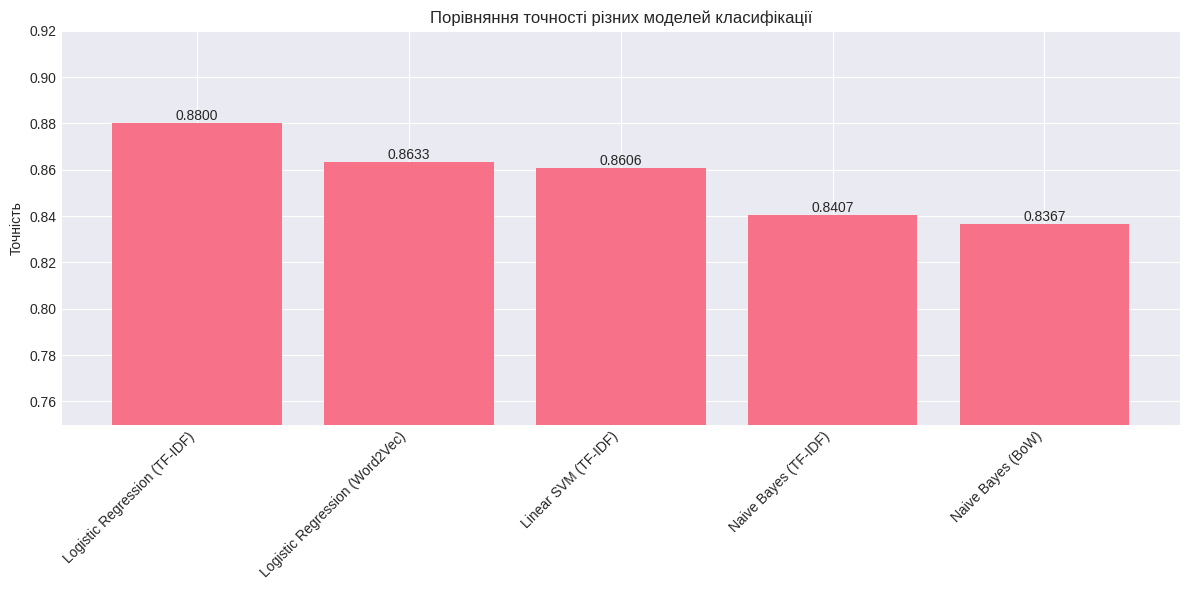

In [ ]:
models_results = {
    'Naive Bayes (BoW)': accuracy_nb_bow,
    'Naive Bayes (TF-IDF)': accuracy_nb_tfidf,
    'Logistic Regression (TF-IDF)': accuracy_lr_tfidf,
    'Logistic Regression (Word2Vec)': accuracy_lr_w2v,
    'Linear SVM (TF-IDF)': accuracy_svm_test
}

results_df = pd.DataFrame(list(models_results.items()), columns=['Модель', 'Точність'])
results_df = results_df.sort_values('Точність', ascending=False)

print("\n" + "="*80)
print("Порівняння моделей")
print("="*80)
print(results_df.to_string(index=False))

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results_df)), results_df['Точність'])
plt.xticks(range(len(results_df)), results_df['Модель'], rotation=45, ha='right')
plt.ylabel('Точність')
plt.title('Порівняння точності різних моделей класифікації')
plt.ylim([0.75, 0.92])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("Детальний звіт класифікації для Linear SVM")
print("="*80)
print(classification_report(y_test, y_pred_svm_test,
                          target_names=['Негативний', 'Позитивний'],
                          digits=4))


Детальний звіт класифікації для Linear SVM
              precision    recall  f1-score   support

  Негативний     0.8556    0.8678    0.8616     12500
  Позитивний     0.8658    0.8535    0.8596     12500

    accuracy                         0.8606     25000
   macro avg     0.8607    0.8606    0.8606     25000
weighted avg     0.8607    0.8606    0.8606     25000



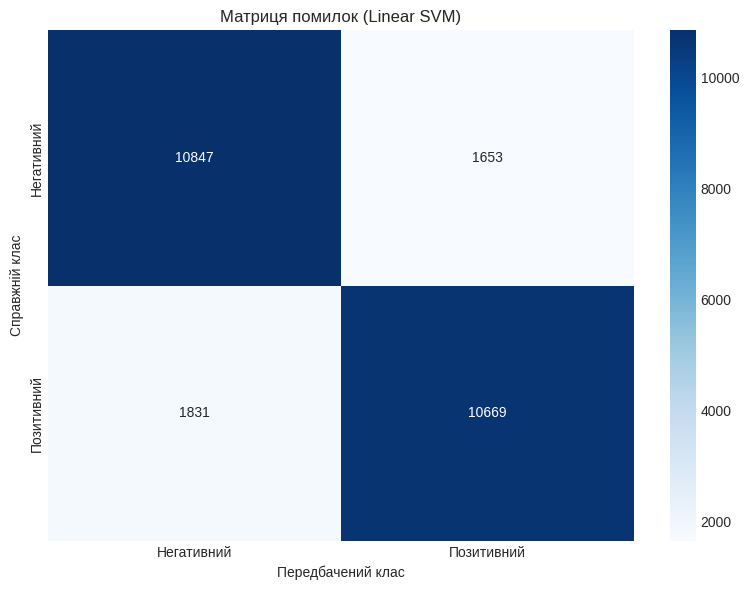


Аналіз матриці помилок:
Правильно класифіковані негативні відгуки: 10847
Помилково класифіковані як позитивні: 1653
Помилково класифіковані як негативні: 1831
Правильно класифіковані позитивні відгуки: 10669


In [ ]:
cm = confusion_matrix(y_test, y_pred_svm_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативний', 'Позитивний'],
            yticklabels=['Негативний', 'Позитивний'])
plt.ylabel('Справжній клас')
plt.xlabel('Передбачений клас')
plt.title('Матриця помилок (Linear SVM)')
plt.tight_layout()
plt.show()

print("\nАналіз матриці помилок:")
print(f"Правильно класифіковані негативні відгуки: {cm[0, 0]}")
print(f"Помилково класифіковані як позитивні: {cm[0, 1]}")
print(f"Помилково класифіковані як негативні: {cm[1, 0]}")
print(f"Правильно класифіковані позитивні відгуки: {cm[1, 1]}")

### b. Аналіз помилок моделі

In [ ]:
errors_idx = np.where(y_pred_svm_test != y_test)[0]

print(f"Загальна кількість помилок: {len(errors_idx)}")
print(f"\nПриклади помилково класифікованих відгуків:")
print("="*80)

false_positives = [idx for idx in errors_idx if y_test[idx] == 0 and y_pred_svm_test[idx] == 1]
print(f"\nНегативні відгуки, класифіковані як позитивні: {len(false_positives)}")
if len(false_positives) > 0:
    print("\nПриклад:")
    idx = false_positives[0]
    print(f"Текст: {X_test_text[idx][:300]}...")
    print(f"Справжній клас: Негативний")
    print(f"Передбачений клас: Позитивний")

false_negatives = [idx for idx in errors_idx if y_test[idx] == 1 and y_pred_svm_test[idx] == 0]
print(f"\n{'-'*80}")
print(f"Позитивні відгуки, класифіковані як негативні: {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nПриклад:")
    idx = false_negatives[0]
    print(f"Текст: {X_test_text[idx][:300]}...")
    print(f"Справжній клас: Позитивний")
    print(f"Передбачений клас: Негативний")

Загальна кількість помилок: 3484

Приклади помилково класифікованих відгуків:

Негативні відгуки, класифіковані як позитивні: 1653

Приклад:
Текст: ? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty b...
Справжній клас: Негативний
Передбачений клас: Позитивний

--------------------------------------------------------------------------------
Позитивні відгуки, класифіковані як негативні: 1831

Приклад:
Текст: ? inspired by hitchcock's strangers on a train concept of two men ? murders in exchange for getting rid of the two people messing up their lives throw ? from the train is an original and very inventive comedy take on the idea it's a credit to danny ? that he both wrote and starred in this minor come...
Справжній клас: Позитивний
Передбаче

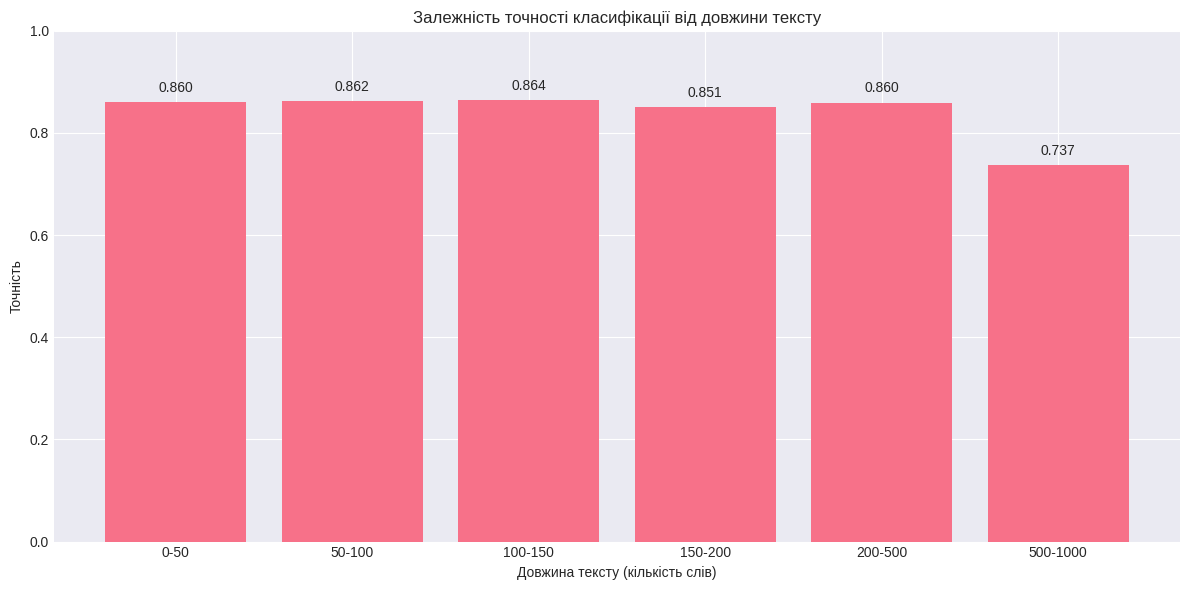

In [ ]:
text_lengths = [len(text.split()) for text in X_test_processed]
correct_predictions = (y_pred_svm_test == y_test)

length_bins = [0, 50, 100, 150, 200, 500, 1000]
bin_accuracies = []

for i in range(len(length_bins)-1):
    mask = (np.array(text_lengths) >= length_bins[i]) & (np.array(text_lengths) < length_bins[i+1])
    if np.sum(mask) > 0:
        acc = np.mean(correct_predictions[mask])
        bin_accuracies.append(acc)
    else:
        bin_accuracies.append(0)

plt.figure(figsize=(12, 6))
bin_labels = [f"{length_bins[i]}-{length_bins[i+1]}" for i in range(len(length_bins)-1)]
plt.bar(range(len(bin_accuracies)), bin_accuracies)
plt.xticks(range(len(bin_accuracies)), bin_labels)
plt.xlabel('Довжина тексту (кількість слів)')
plt.ylabel('Точність')
plt.title('Залежність точності класифікації від довжини тексту')
plt.ylim([0, 1])

for i, acc in enumerate(bin_accuracies):
    plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center')

plt.tight_layout()
plt.show()